In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import sem
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import ttest_rel,ttest_ind,wilcoxon
import json
import statsmodels.api as sm
import pylab as py

from tqdm import trange

In [3]:
import sys
sys.path.append('/Users/dbao/Downloads/research/rc_scripts/analysis')
import final_analysis.plot_helper.format
save_mode = '.pdf'

In [4]:
# home_dir = '/Users/dbao/google_drive_db'+'/road_construction/data/2022_online/'
# home_dir = '../../../2022_online/'
home_dir = '/Users/dbao/Library/CloudStorage/GoogleDrive-sherrydbao@gmail.com/.shortcut-targets-by-id/1sYZNVBbYCrHcHjo-9xdKcA4wLnob9ZEq/'+'/road_construction/data/2022_online/'
map_dir = 'active_map/'
data_dir  = 'data/preprocessed'
# out_dir = home_dir + 'figures/cogsci_2022/'
out_dir = home_dir + 'figures/figures_final/'
R_out_dir = home_dir + 'R_analysis_data/'

In [5]:
data_puzzle_level = pd.read_csv(R_out_dir +  'data.csv')
puzzleID_order_data = data_puzzle_level.sort_values(["subjects","puzzleID"])
data_choice_level = pd.read_csv(R_out_dir +  'choice_level/choicelevel_data.csv')

single_condition_data = puzzleID_order_data[puzzleID_order_data['condition']==1].copy()
single_condition_data = single_condition_data.reset_index()
sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index()

## Matched length sequence's MAS

In [6]:
print(single_condition_data.subjects)

0        0
1        0
2        0
3        0
4        0
        ..
4595    99
4596    99
4597    99
4598    99
4599    99
Name: subjects, Length: 4600, dtype: int64


In [7]:
print(single_condition_data.keys())

Index(['index', 'subjects', 'puzzleID', 'action_gap', 'condition', 'trialID',
       'block', 'reward', 'numCities', 'mas', 'nos', 'leftover', 'numUNDO',
       'numEnd', 'TT', 'RT1', 'RTsubmit', 'numError', 'sumSeverityErrors',
       'final_sumSeverityErrors', 'final_missed_reward', 'final_error_rate',
       'SeverityError1', 'numFullUndo', 'RTlater'],
      dtype='object')


In [8]:

undo_level = data_choice_level[data_choice_level['condition']==1].copy().reset_index()
basic_level = data_choice_level[data_choice_level['condition']==0].copy().reset_index()

mas_gain = []
for sub in range(100):
    mas_gain_length = []
    print('sub{}'.format(sub))
    dat_sbj_undo  = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_basic = basic_level[basic_level['subjects']==sub].sort_values(["puzzleID","index"])

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi].reset_index()
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID'] == pzi].reset_index()

        mas_gain_length.append(dat_sbj_undo_pzi['currMas'].iloc[-1] - dat_sbj_basic_pzi['currMas'].iloc[-1])
    mas_gain.append(mas_gain_length)
mas_gain = np.array(mas_gain)

sub0
sub1
sub2
sub3
sub4
sub5
sub6
sub7
sub8
sub9
sub10
sub11
sub12
sub13
sub14
sub15
sub16
sub17
sub18
sub19
sub20
sub21
sub22
sub23
sub24
sub25
sub26
sub27
sub28
sub29
sub30
sub31
sub32
sub33
sub34
sub35
sub36
sub37
sub38
sub39
sub40
sub41
sub42
sub43
sub44
sub45
sub46
sub47
sub48
sub49
sub50
sub51
sub52
sub53
sub54
sub55
sub56
sub57
sub58
sub59
sub60
sub61
sub62
sub63
sub64
sub65
sub66
sub67
sub68
sub69
sub70
sub71
sub72
sub73
sub74
sub75
sub76
sub77
sub78
sub79
sub80
sub81
sub82
sub83
sub84
sub85
sub86
sub87
sub88
sub89
sub90
sub91
sub92
sub93
sub94
sub95
sub96
sub97
sub98
sub99


In [9]:
mas_gain_persub = mas_gain.mean(axis=1)

In [10]:
mas_diff = []
data_error_rate = []
currnctsss = []

mas_diff_foreach = []
data_error_rate_foreach = []

max_diff_ = []

data_all_ = pd.DataFrame(columns=['mas', 'mas_ref', 'cumerror', 'cumerror_move', 'cumerror_ref', 'do_redo', 'length_redo', 'nct', 'sub', 'puzzle'])
data_diff_ = pd.DataFrame(columns=['mas_diff', 'cumerror_diff', 'cumerror_movediff', 'length_redo', 'nct', 'sub', 'puzzle'])


for sub in trange(100):
    mas_gain_length = []
    dat_sbj_undo  = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_basic = basic_level[basic_level['subjects']==sub].sort_values(["puzzleID","index"])


    dat_sbj = sc_data_choice_level[sc_data_choice_level['subjects'] == sub].sort_values(["puzzleID", "index"])

    max_diff_puzzle = []
    mas_gain_length = []

    for pzi in np.unique(sc_data_choice_level['puzzleID']):

        # for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()

        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi].reset_index()
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID'] == pzi].reset_index()

        mas_gain_length.append(dat_sbj_undo_pzi['currMas'].iloc[-1] - dat_sbj_basic_pzi['currMas'].iloc[-1])

        firstUndo_idx = dat_sbj_pzi[dat_sbj_pzi["firstUndo"] == 1].index
        path_bf_undo = dat_sbj_pzi["currMas"][firstUndo_idx - 1]  # the mas of the state before undo

        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"] == 1].index
        path_af_undo = dat_sbj_pzi["currMas"][lastUndo_idx + 1]  # the mas of the state after undo

        submit_idx = pd.Int64Index([len(dat_sbj_pzi) - 1])

        # print(tidx)

        length_mas_diff = []
        
        length_error_rate = []
        length_error_rate_foreach = []
        len_num_visit_states = []
        length_error_rate_UNA = []

        # if dat_sbj_undo_pzi['firstUndo'].sum() == 1: # meaning only single undo puzzle will be considered

        if len(firstUndo_idx) > 0:
            if len(firstUndo_idx) == 1:  #
                t_idx = (firstUndo_idx[1:] - 1).to_list()
                t_idx.append(submit_idx.item())
                seq_bf = dat_sbj_pzi["path"][firstUndo_idx - 1]
                seq_af = dat_sbj_pzi["path"][t_idx]
                seq_im = dat_sbj_pzi["path"][lastUndo_idx]
                currmas_bf = dat_sbj_pzi["currMas"][lastUndo_idx - 1]
                currmas_af = dat_sbj_pzi["currMas"][lastUndo_idx + 1]

            else:
                seq_bf = dat_sbj_pzi["path"][firstUndo_idx - 1]
                t_idx = (firstUndo_idx[1:] - 1).to_list()
                t_idx.append(submit_idx.item())
                seq_af = dat_sbj_pzi["path"][t_idx]
                seq_im = dat_sbj_pzi["path"][lastUndo_idx]
                currmas_bf = dat_sbj_pzi["currMas"][lastUndo_idx - 1]
                currmas_af = dat_sbj_pzi["currMas"][lastUndo_idx + 1]

            seq_im = seq_im.reset_index()
            pathStr_im = [seq_im.loc[i].path.strip('[').strip(']') for i in range(len(seq_im))]
            pathList_im = [[int(i) for i in pathStr_im[j].split(', ')]  for j in range(len(pathStr_im))]
            pathStr_im = [" ".join([str(a) for a in pathList_im[j]]) for j in range(len(seq_im))]

            seq_bf = seq_bf.reset_index()
            pathStr_bf = [seq_bf.loc[i].path.strip('[').strip(']') for i in range(len(seq_bf))]
            pathList_bf = [[int(i) for i in pathStr_bf[j].split(', ')]  for j in range(len(pathStr_bf))]
            pathStr_bf = [" ".join([str(a) for a in pathList_bf[j]]) for j in range(len(seq_bf))]

            seq_af = seq_af.reset_index()
            pathStr_af = [seq_af.loc[i].path.strip('[').strip(']') for i in range(len(seq_af))]
            pathList_af = [[int(i) for i in pathStr_af[j].split(', ')]  for j in range(len(pathStr_af))]
            pathStr_af = [" ".join([str(a) for a in pathList_af[j]]) for j in range(len(seq_af))]

            firstundoidx = firstUndo_idx.to_numpy()-1

            # print(firstundoidx)

            do_redo = []
            
            lastundoidx = lastUndo_idx.to_numpy()
            # print(t_idx)
            tidx = np.array(t_idx) + 1
            tidx[-1] -= 1 # for the submit action
            for i in range(len(firstundoidx)):
                currnct = dat_sbj_pzi["currNumCities"][firstundoidx[i]:tidx[i]].to_numpy()
                currnct2 = currnct.copy()
                currmas = dat_sbj_pzi["currMas"][firstundoidx[i]:tidx[i]].to_numpy()
                currnct = currnct - min(currnct)
                currpath = dat_sbj_pzi["path"][firstundoidx[i]:tidx[i]].to_list()
                currpath = [currpath[i].strip('[').strip(']') for i in range(len(currpath))]
                currpath = [[int(i) for i in currpath[j].split(', ')] for j in range(len(currpath))]
                
                currchoice = dat_sbj_pzi["choice"][firstundoidx[i]:tidx[i]].to_numpy()

                errors_ = dat_sbj_pzi["error"][firstundoidx[i]:tidx[i]].to_numpy()

                currRT = dat_sbj_pzi["RT"][firstundoidx[i]:tidx[i]].to_numpy()
                currundoRT = dat_sbj_pzi["undoRT"][firstundoidx[i]:tidx[i]].to_numpy()

                seq_im = dat_sbj_pzi["path"][lastundoidx[i]]
                pathStr_im = seq_im.strip('[').strip(']')
                pathList_im = [int(i) for i in pathStr_im.split(', ')]

                currpath = [np.setdiff1d(currpath[i], pathList_im).tolist() for i in range(len(currpath))]
                pathafter = [np.setdiff1d(pathList_af[i], pathList_im).tolist() for i in range(len(pathList_af))]
                idx_2 = np.where(currnct==0)[0]
                if len(idx_2)>1:
                    idx_2 = idx_2[0]
                else:
                    idx_2 = idx_2[0]

                currnct_do  = currnct2[:idx_2+1]
                currnct_redo = currnct2[idx_2:]
                
                currmas_do = currmas[:idx_2+1]
                currmas_redo = currmas[idx_2:]
                
                choice_do = currchoice[:idx_2+1]
                choice_redo = currchoice[idx_2:]
                
                
                length_do = min(currnct_do.max(), currnct_redo.max())
                do_where = np.where(currnct_do==length_do)[0].squeeze() + 1
                redo_where = np.where(currnct_redo==length_do)[0].squeeze() + 1
                                
                
                if currnct[-1]==0:
                    # this means this perseon undo and submitted
                    continue
                else:
                    length_mas_diff.append([np.abs(currmas_do[:do_where][-1]-currmas_do[:do_where][0].squeeze()), 
                                            np.abs(currmas_redo[:redo_where][-1]-currmas_redo[:redo_where][0].squeeze())])

                    data_all_ = pd.concat([data_all_, pd.DataFrame({'mas': [currmas_do[:do_where][-1]], 
                                                'mas_ref': [np.abs(currmas_do[:do_where][0].squeeze() - dat_sbj_pzi["currMas"].to_numpy()[idx_2])],
                                                'cumerror': [np.abs(currmas_do[:do_where][-1]-dat_sbj_pzi["currMas"].to_numpy()[0])],
                                                'cumerror_ref': [currmas[idx_2]-currmas_do[:do_where][-1].squeeze()],
                                                'cumerror_move': [currmas[idx_2]-currmas_do[-2]],
                                                'do_redo': ['do'], 
                                                'length_redo': [min(len(currmas_do), len(currmas_redo))], 
                                                'nct': [length_do], 
                                                'sub': [sub], 
                                                'puzzle': [pzi]})], ignore_index=True)
                    
                    data_all_ = pd.concat([data_all_, pd.DataFrame({'mas': [currmas_redo[:redo_where][-1]], 
                                                'mas_ref': [np.abs(currmas_redo[:redo_where][0].squeeze() - dat_sbj_pzi["currMas"].to_numpy()[idx_2])],
                                                'cumerror': [np.abs(currmas_redo[:redo_where][-1]-dat_sbj_pzi["currMas"].to_numpy()[0])],
                                                'cumerror_ref': [currmas[idx_2]-currmas_redo[:redo_where][-1].squeeze()],
                                                'cumerror_move': [currmas[idx_2]-currmas_redo[1]],
                                                'do_redo': ['redo'],
                                                'length_redo': [min(len(currmas_do), len(currmas_redo))],
                                                'nct': [length_do],
                                                'sub': [sub],
                                                'puzzle': [pzi]})], ignore_index=True)
                    
                    if data_all_['cumerror_ref'].iloc[-2] <0 or data_all_['cumerror_ref'].iloc[-1] <0:
                        breakee
                        
                    
                    data_diff_ = pd.concat([data_diff_, pd.DataFrame({'mas_diff': [currmas_do[:do_where][-1].squeeze()-currmas_redo[:redo_where][0].squeeze()],
                                                    'cumerror_diff': [np.abs(currmas_redo[:redo_where][-1]-currmas_redo[:redo_where][0].squeeze()) - np.abs(currmas_do[:do_where][-1]-currmas_do[:do_where][0].squeeze())],
                                                    'cumerror_movediff': [np.abs(currmas_do[-2] - currmas_redo[1])],
                                                    'length_redo': [min(len(currmas_do), len(currmas_redo))],
                                                    'nct': [length_do],
                                                    'sub': [sub],
                                                    'puzzle': [pzi]})], ignore_index=True)
                    if currnct_do[:do_where][-1] != currnct_redo[:redo_where][-1]:
                        print('error')
                    
                    
                    # data_all_=data_all_.append({'mas_diff': np.abs(currmas_UNA[:length_do][-1]-currmas_UNA[:length_do][0].squeeze()),
                    #                     'do_redo': 'UNA', 'length_redo': min(len(currmas_do), len(currmas_redo)), 'sub': sub, 'puzzle': pzi}, ignore_index=True)

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_83467/2462439613.py:41: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  submit_idx = pd.Int64Index([len(dat_sbj_pzi) - 1])
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_83467/2462439613.py:41: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  submit_idx = pd.Int64Index([len(dat_sbj_pzi) - 1])
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_83467/2462439613.py:41: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  submit_idx = pd.Int64Index([len(dat_sbj_pzi) - 1])
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_83467/2462439613.py:41: FutureWarni

In [11]:
grouped = data_all_.groupby(['do_redo', 'sub']).mean(numeric_only=True)

data_do = data_all_[data_all_['do_redo'] == 'do']
data_redo = data_all_[data_all_['do_redo'] == 'redo']
# data_una = data_all_[data_all_['do_redo'] == 'UNA']


# *Bar plots for cumulative error magnitude

Removed UNA condition's bar since no longer comparing it to the control because it is not the control anymore.


In [12]:
mean_do = data_do.groupby(['sub']).mean()['cumerror'].mean()
mean_redo = data_redo.groupby(['sub']).mean()['cumerror'].mean()

sem_do = data_do.groupby(['sub']).mean()['cumerror'].sem()
sem_redo = data_redo.groupby(['sub']).mean()['cumerror'].sem()

print(mean_do, mean_redo)
print(sem_do, sem_redo)

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_83467/3657357709.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  mean_do = data_do.groupby(['sub']).mean()['cumerror'].mean()
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_83467/3657357709.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  mean_redo = data_redo.groupby(['sub']).mean()['cumerror'].mean()


1.3476139748436113 0.8718638005776741
0.06074299287824911 0.038119267555844126


/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_83467/3657357709.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  sem_do = data_do.groupby(['sub']).mean()['cumerror'].sem()
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_83467/3657357709.py:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  sem_redo = data_redo.groupby(['sub']).mean()['cumerror'].sem()


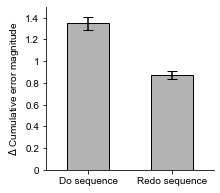

In [13]:
%matplotlib inline

# bar plot of error rate (do), error rate (redo) and error rate undo_not_allowed condition
# each corresponds to data_['error_rate_do'], data_['error_rate_redo'], data_['error_rate_UNA']

# set font and font size
# plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 12

# fig, ax = plt.subplots(1,1,figsize=(5,5))
fig, ax = plt.subplots(1,1,figsize=(3,3))

# plot bar plot

sns.despine()
# ax.bar([0,1,2], [mean_do, mean_redo, mean_una], yerr=[sem_do, sem_redo, sem_una], color=[.7,.7,.7], edgecolor='k', capsize=5)
ax.bar([0,1], [mean_do, mean_redo], yerr=[sem_do, sem_redo], color=[.7,.7,.7], edgecolor='k', capsize=5, width=0.5)

# ylabel
ax.set_ylabel('$\Delta$ Cumulative error magnitude')
# set yticks

ax.set_xlim([-0.5, 1.5])
ax.set_ylim([0, 1.5])
# ax.set_yticks([0, 0.3, 0.6, 0.9, 1.2, 1.5])
# ax.set_yticklabels(['0', '0.3', '0.6', '0.9', '1.2', '1.5'])
# ax.set_yticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
# ax.set_yticklabels(['0', '0.25', '0.5', '0.75', '1', '1.25', '1.5'])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4])
ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1', '1.2', '1.4'])

# xtickslabel
ax.set_xticks([0,1])
ax.set_xticklabels(['Do sequence', 'Redo sequence'])


# save figure
fig.savefig(out_dir + 'error_rate_do_redo_UNA'+save_mode, transparent=True,
            bbox_inches='tight', pad_inches=0.1)

## Same bar plots but for moves.

In [14]:
mean_do = data_do.groupby(['sub']).mean()['cumerror_move'].mean()
mean_redo = data_redo.groupby(['sub']).mean()['cumerror_move'].mean()

sem_do = data_do.groupby(['sub']).mean()['cumerror_move'].sem()
sem_redo = data_redo.groupby(['sub']).mean()['cumerror_move'].sem()

print(mean_do, mean_redo)
print(sem_do, sem_redo)

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_83467/2223007921.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  mean_do = data_do.groupby(['sub']).mean()['cumerror_move'].mean()
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_83467/2223007921.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  mean_redo = data_redo.groupby(['sub']).mean()['cumerror_move'].mean()
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_83467/2223007921.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid

0.6754917036010231 0.3575033936441243
0.04310064338292065 0.027882351326259013


/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_83467/2223007921.py:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  sem_redo = data_redo.groupby(['sub']).mean()['cumerror_move'].sem()


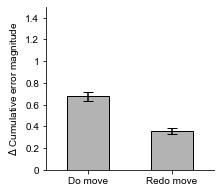

In [15]:
%matplotlib inline

# bar plot of error rate (do), error rate (redo) and error rate undo_not_allowed condition
# each corresponds to data_['error_rate_do'], data_['error_rate_redo'], data_['error_rate_UNA']

# set font and font size
# plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 12

# fig, ax = plt.subplots(1,1,figsize=(5,5))
fig, ax = plt.subplots(1,1,figsize=(3,3))

# plot bar plot

sns.despine()
# ax.bar([0,1,2], [mean_do, mean_redo, mean_una], yerr=[sem_do, sem_redo, sem_una], color=[.7,.7,.7], edgecolor='k', capsize=5)
ax.bar([0,1], [mean_do, mean_redo], yerr=[sem_do, sem_redo], color=[.7,.7,.7], edgecolor='k', capsize=5, width=0.5)

# ylabel
ax.set_ylabel('$\Delta$ Cumulative error magnitude')
# set yticks

ax.set_xlim([-0.5, 1.5])
ax.set_ylim([0, 1.5])
# ax.set_yticks([0, 0.3, 0.6, 0.9, 1.2, 1.5])
# ax.set_yticklabels(['0', '0.3', '0.6', '0.9', '1.2', '1.5'])
# ax.set_yticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
# ax.set_yticklabels(['0', '0.25', '0.5', '0.75', '1', '1.25', '1.5'])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4])
ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1', '1.2', '1.4'])
# ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

# xtickslabel
ax.set_xticks([0,1])
ax.set_xticklabels(['Do move', 'Redo move'])


# save figure
fig.savefig(out_dir + 'error_rate_do_redo_move'+save_mode, transparent=True,
            bbox_inches='tight', pad_inches=0.1)

# Bar plots for mps


# lmm results